# Country Guesser : Rapport interactif

## Sujet

Le sujet était imposé, implémenté un PMC dans le but de pouvoir classifier 3 drapeaux nationaux
Les drapeaux choisis sont les suivants : Jordanie, Palestine, Soudan

Pourquoi ceux là ? Car ils se ressemblent énormément et qu\'il est difficile pour la plupart des
personnes intérogées, de les distinguer les uns des autres.

## Dataset

Le dataset est constitué d'environ 250 images par drapeau, aux alentours de 200 pour l'entraînement
et de 40 pour le test.

Les images ont été récupérés à l'aide d'extensions chrome afin de télécharger toutes les images d'une même
page. Les drapeaux n'étant pas aussi populaires que d'autres drapeaux (européens par exemple) il a fallut
allait en télécharger sur différents moteurs de recherche

## Librairie

Le perceptron multicouche a été implémenté en C++

## Application

L'application a été développé à l'aide du framework streamlit pour sa simplicité et son apparence. J'ai également
utilisé ngrok afin de pouvoir déployé l'application en local, voir en ligne.

## Imports

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
from ctypes import *
from image import *
from conf import *
import numpy as np
from mlp import *
import os

## Import du dataset

In [62]:
def transform_image(img, img_size):
    img = img.resize((img_size, img_size))

    if img.mode == "RGBA":
        rgba = np.array(img)
        rgba[rgba[..., -1] == 0] = [255, 255, 255, 0]
        img = Image.fromarray(rgba)
    img = img.convert("RGB")

    return img

In [63]:
def fill_x_and_y_with_images_and_labels(folder, x_list, y_list, label, img_size):
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        image = Image.open(file_path)
        img = transform_image(image, img_size)
        hor_flip = img.transpose(Image.FLIP_LEFT_RIGHT)
        ver_flip = img.transpose(Image.FLIP_TOP_BOTTOM)

        ims_arr = []
        ims_arr.append(np.array(img))
        ims_arr.append(np.array(hor_flip))
        ims_arr.append(np.array(ver_flip))

        for arr in ims_arr:
            arr = arr.flatten()
            arr = arr / 255.0
            x_list.append(arr)
            y_list.append(label)

In [64]:
def import_dataset(img_size=IMAGE_SIZE, dataset=DATASET_FOLDER2):
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    classes = list(CLASSES)
    if dataset == DATASET_FOLDER3:
        classes = ["allemagne", "france", "italie"]
    print(classes)

    train_first_folder = os.path.join(dataset, f"train/{classes[0]}").replace(os.sep, '/')
    train_second_folder = os.path.join(dataset, f"train/{classes[1]}").replace(os.sep, '/')
    train_third_folder = os.path.join(dataset, f"train/{classes[2]}").replace(os.sep, '/')

    test_first_folder = os.path.join(dataset, f"test/{classes[0]}").replace(os.sep, '/')
    test_second_folder = os.path.join(dataset, f"test/{classes[1]}").replace(os.sep, '/')
    test_third_folder = os.path.join(dataset, f"test/{classes[2]}").replace(os.sep, '/')

    fill_x_and_y_with_images_and_labels(train_first_folder, x_train, y_train, [1, -1, -1], img_size)
    fill_x_and_y_with_images_and_labels(train_second_folder, x_train, y_train, [-1, 1, -1], img_size)
    fill_x_and_y_with_images_and_labels(train_third_folder, x_train, y_train, [-1, -1, 1], img_size)

    fill_x_and_y_with_images_and_labels(test_first_folder, x_test, y_test, [1, -1, -1], img_size)
    fill_x_and_y_with_images_and_labels(test_second_folder, x_test, y_test, [-1, 1, -1], img_size)
    fill_x_and_y_with_images_and_labels(test_third_folder, x_test, y_test, [-1, -1, 1], img_size)

    return (np.array(x_train).astype(np.float), np.array(y_train).astype(np.float)), \
           (np.array(x_test).astype(np.float), np.array(y_test).astype(np.float))

In [9]:
(x_train, y_train), (x_test, y_test) = import_dataset()

['jordanie', 'palestine', 'soudan']


## Exemple avec une image

In [89]:
image = Image.open("C:/Users/Erwan san/Desktop/Country_guesser/resized_dataset/train/jordanie/  (1).jpeg")
img = transform_image(image, IMAGE_SIZE)
img.show()
hor_flip = img.transpose(Image.FLIP_LEFT_RIGHT)
ver_flip = img.transpose(Image.FLIP_TOP_BOTTOM)
hor_flip.show()
ver_flip.show()

Pour chaque image du dataset on se retrouve donc avec 3 images au total.
Il était prévu de générer deux autres images, les deux issues d'une rotation, une à 45 degrès et une
autre à 90 degrés à l'aide de la méthode .rotate()

Malheureusement, 1 image sur 3 environ issue d'une rotation donnait une image noire.
Il s'agissait peut-être d'un problème de dimension mais je n'ai pas plus creuser la piste

## Prédictions sur notre dataset

Voyons le taux de prédiction qu'obtient un simple modèle non entrainé d'une couche cachée de 8 neurones
sur notre dataset d'entraînement

### Création du modèle

In [84]:
np_arr = np.array([len(x_train[0]), 8, 3])
npl = np.ctypeslib.as_ctypes(np_arr)
model = create_mlp_model(npl)

### Predictions

In [87]:
predicted_outputs = [predict_mlp_model_classification(model, x, 3) for x in x_train]
acc = 0
for p, y in zip(predicted_outputs, y_train):
    if np.argmax(p) == np.argmax(y):
        acc += 1

print("Prédiction sur notre dataset d'entraînement : ", acc / len(predicted_outputs) * 100, "%")

Prédiction sur notre dataset d'entraînement :  28.058361391694724 %


On est généralement autour de 1/3 ...

### Entraînement et nouvelles prédictions

Entraînons maintenant notre modèle un peu afin de voir s'il apprend correctement ou non
On prend un pas d'apprentissage arbitraire de 0.01, et un nombre d'épochs de 10000

In [88]:
train_classification_stochastic_backprop_mlp_model(model, x_train.flatten(), y_train.flatten(), 0.01, 10000)

predicted_train_outputs_after_training = [predict_mlp_model_classification(model, x, 3) for x in x_train]
acc = 0
for p, y in zip(predicted_train_outputs_after_training, y_train):
    if np.argmax(p) == np.argmax(y):
        acc += 1
acc = acc / len(predicted_train_outputs_after_training) * 100
print("Prédiction sur notre dataset d'entraînement, après entraînement : ", acc, "%")

predicted_test_outputs_after_training = [predict_mlp_model_classification(model, x, 3) for x in x_test]
test_acc = 0
for p, y in zip(predicted_test_outputs_after_training, y_test):
    if np.argmax(p) == np.argmax(y):
        test_acc += 1
test_acc = test_acc / len(predicted_test_outputs_after_training) * 100
print("Prédiction sur notre dataset de test, après entraînement : ", test_acc, "%")

destroy_mlp_model(model)

Prédiction sur notre dataset d'entraînement, après entraînement :  61.335578002244674 %
Prédiction sur notre dataset de test, après entraînement :  65.12345679012346 %


On se rapproche de quelque chose d'intéressant, ce petit modèle fait certainement mieux que du random, en jouant avec
nos différents hyperparamètres nous devrions nous approcher d'un modèle performant.

### Courbes d'apprentissage

Affichons maintenat les courbes d'apprentissages, de loss (différence entre les résultats obtenus et ce que l'on attendait)
et d'accuracy (taux de bonne réponse)

In [17]:
from IPython.core.display import clear_output


def show_graphs(model, epochs):
    losses = []
    test_losses = []
    accs = []
    test_accs = []
    (x_train, y_train), (x_test, y_test) = import_dataset()
    for epoch in range(epochs):
        print(f"Epoch numéro {epoch} en cours ..")
        train_classification_stochastic_backprop_mlp_model(model, x_train.flatten(), y_train.flatten(), alpha=0.007, epochs=len(x_train))

        train_predicted_outputs = [predict_mlp_model_classification(model, x, 3) for x in x_train]
        loss = mean_squared_error(y_train, train_predicted_outputs)
        losses.append(loss)

        test_predicted_outputs = [predict_mlp_model_classification(model, x, 3) for x in x_test]
        test_loss = mean_squared_error(y_test, test_predicted_outputs)
        test_losses.append(test_loss)

        acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_predicted_outputs, axis=1))
        # acc = accuracy_score(y_train, train_predicted_outputs)
        accs.append(acc)

        test_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_predicted_outputs, axis=1))
        # test_acc = accuracy_score(y_test, test_predicted_outputs)
        # ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets
        test_accs.append(test_acc)

        clear_output(True)

        plt.plot(losses)
        plt.plot(test_losses)
        plt.legend(['loss', 'val_loss'], loc='upper left')
        plt.title('Evolution of loss (CCE)')
        plt.xlabel('epochs')
        plt.ylabel(f'categorical cross-entropy (softmax loss)')
        plt.show()

        plt.plot(accs)
        plt.plot(test_accs)
        plt.legend(['acc', 'val_acc'], loc='upper left')
        plt.title('Evolution of accuracy')
        plt.xlabel('epochs')
        plt.ylabel(f'Accuracy (%)')
        plt.show()

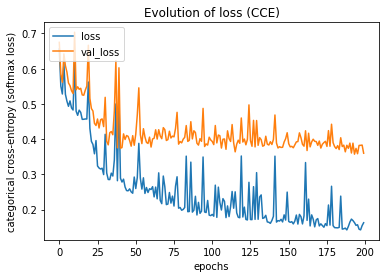

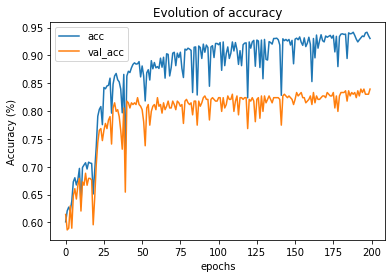

In [18]:
np_arr = np.array([len(x_train[0]), 3, 3])
npl = np.ctypeslib.as_ctypes(np_arr)
model = create_mlp_model(npl)
show_graphs(model, 100)
destroy_mlp_model(model)